In [41]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We start by converting our CSV file into a SQLite Database.

In [42]:
csv_file_path = 'data/annual-number-of-deaths-by-cause.csv'

db_file_path = 'deathdata.db'

conn = sqlite3.connect(db_file_path)

try:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)

    # Drop the table if it already exists
    conn.execute('DROP TABLE IF EXISTS death_causes')

    # Write the data to a SQLite table
    df.to_sql('death_causes', conn, index=False, if_exists='replace')

    # Check if the table was created
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print("Tables in the database:", tables)

except Exception as e:
    print("An error occurred:", e)

finally:
    conn.close()

Tables in the database: [('death_causes',)]


# Learning the ropes

Then we got comfortable with the database and the libraries by making our first pie chart.

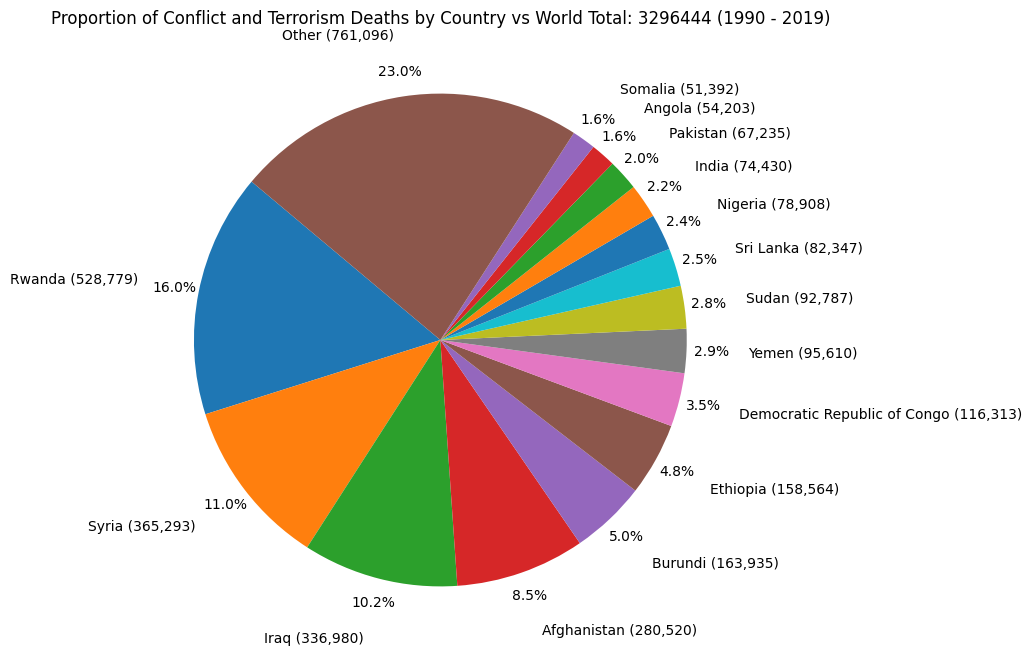

In [43]:
conn = sqlite3.connect('summary1.db')

# Query to get the total deaths for 'World'
world_query = """
SELECT total_deaths 
FROM country_conflict_deaths_summary
WHERE country = 'World'
"""
world_result = pd.read_sql(world_query, conn)
if not world_result.empty:
    world_deaths = world_result['total_deaths'].iloc[0]
else:
    world_deaths = "Unavailable"

# Query the summed data from the database, excluding 'World' and other group entities
exclusions = ( 'World', 'World Bank High Income', 
        'World Bank Low Income', 'World Bank Upper Middle Income', 
        'African Region (WHO)', 'Sub-Saharan Africa (WB)', 
        'Eastern Mediterranean Region (WHO)', 'World Bank Lower Middle Income',
        'Middle East & North Africa (WB)', 'South Asia'
        'South-East Asia Region (WHO)', 'European Region (WHO)',
        'Europe & Central Asia (WB)', 'South Asia (WB)',
        'South-East Asia Region (WHO)', 'G20',
        'East Asia & Pacific (WB)', 'Region of the Americas (WHO)',
        'Latin America & Caribbean (WB)', 'OECD Countries',
        'Western Pacific Region (WHO)')  # Adjust to exclude any aggregated groups

query = f"""
SELECT country, total_deaths 
FROM country_conflict_deaths_summary
WHERE country NOT IN {exclusions}
ORDER BY total_deaths DESC
"""
data = pd.read_sql(query, conn)

conn.close()

# Calculate the 'Other' category for countries with small numbers
threshold = 50000
filtered_data = data[data['total_deaths'] > threshold]
other_sum = data[data['total_deaths'] <= threshold]['total_deaths'].sum()

# Append 'Other' category if needed using pd.concat
if other_sum > 0:
    other_data = pd.DataFrame({'country': ['Other'], 'total_deaths': [other_sum]})
    filtered_data = pd.concat([filtered_data, other_data], ignore_index=True)

# Create labels that include the death toll for each slice
labels = [f'{row["country"]} ({row["total_deaths"]:,})' for index, row in filtered_data.iterrows()]

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(filtered_data['total_deaths'], labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=1.1, labeldistance=1.25)
plt.title(f'Proportion of Conflict and Terrorism Deaths by Country vs World Total: {world_deaths} (1990 - 2019)')
plt.show()

# Finding our goal

We made the decision to focus on trends in the data we have (Causes of death 1990 - 2019)

Our audience is researchers, doctors and journalists that want to see development in causes of death (CoD) between the years 1990 - 2019.

# But first, another pie chart

We wanted to see the leading CoD worldwide in order to see what our points of interest will be.

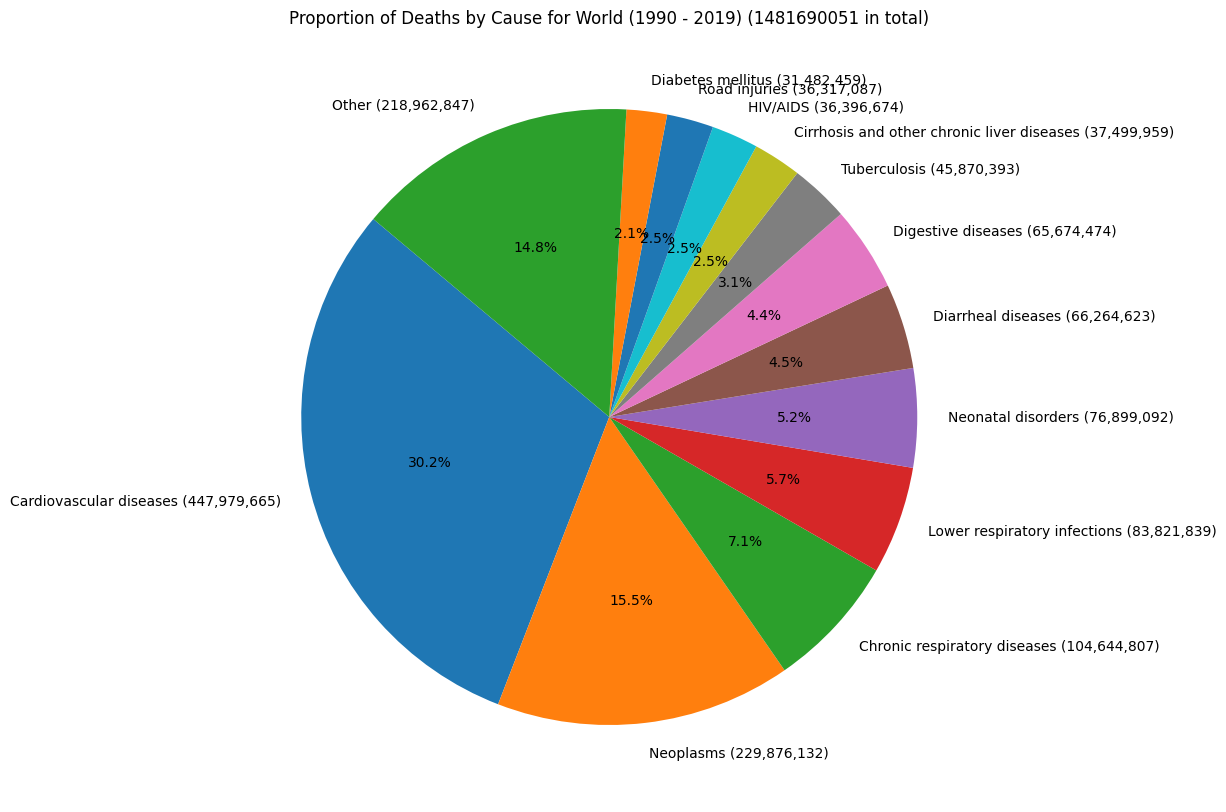

In [44]:
conn = sqlite3.connect('deathdata.db')

# Define the causes and their respective SQL aliases
causes = [
    '"Deaths - Meningitis - Sex: Both - Age: All Ages (Number)" AS "Meningitis"',
    '"Deaths - Alzheimer\'s disease and other dementias - Sex: Both - Age: All Ages (Number)" AS "Alzheimer\'s disease and other dementias"',
    '"Deaths - Parkinson\'s disease - Sex: Both - Age: All Ages (Number)" AS "Parkinson\'s disease"',
    '"Deaths - Nutritional deficiencies - Sex: Both - Age: All Ages (Number)" AS "Nutritional deficiencies"',
    '"Deaths - Malaria - Sex: Both - Age: All Ages (Number)" AS "Malaria"',
    '"Deaths - Drowning - Sex: Both - Age: All Ages (Number)" AS "Drowning"',
    '"Deaths - Interpersonal violence - Sex: Both - Age: All Ages (Number)" AS "Interpersonal violence"',
    '"Deaths - Maternal disorders - Sex: Both - Age: All Ages (Number)" AS "Maternal disorders"',
    '"Deaths - HIV/AIDS - Sex: Both - Age: All Ages (Number)" AS "HIV/AIDS"',
    '"Deaths - Drug use disorders - Sex: Both - Age: All Ages (Number)" AS "Drug use disorders"',
    '"Deaths - Tuberculosis - Sex: Both - Age: All Ages (Number)" AS "Tuberculosis"',
    '"Deaths - Cardiovascular diseases - Sex: Both - Age: All Ages (Number)" AS "Cardiovascular diseases"',
    '"Deaths - Lower respiratory infections - Sex: Both - Age: All Ages (Number)" AS "Lower respiratory infections"',
    '"Deaths - Neonatal disorders - Sex: Both - Age: All Ages (Number)" AS "Neonatal disorders"',
    '"Deaths - Alcohol use disorders - Sex: Both - Age: All Ages (Number)" AS "Alcohol use disorders"',
    '"Deaths - Self-harm - Sex: Both - Age: All Ages (Number)" AS "Self-harm"',
    '"Deaths - Exposure to forces of nature - Sex: Both - Age: All Ages (Number)" AS "Exposure to forces of nature"',
    '"Deaths - Diarrheal diseases - Sex: Both - Age: All Ages (Number)" AS "Diarrheal diseases"',
    '"Deaths - Environmental heat and cold exposure - Sex: Both - Age: All Ages (Number)" AS "Environmental heat and cold exposure"',
    '"Deaths - Neoplasms - Sex: Both - Age: All Ages (Number)" AS "Neoplasms"',
    '"Deaths - Conflict and terrorism - Sex: Both - Age: All Ages (Number)" AS "Conflict and terrorism"',
    '"Deaths - Diabetes mellitus - Sex: Both - Age: All Ages (Number)" AS "Diabetes mellitus"',
    '"Deaths - Chronic kidney disease - Sex: Both - Age: All Ages (Number)" AS "Chronic kidney disease"',
    '"Deaths - Poisonings - Sex: Both - Age: All Ages (Number)" AS "Poisonings"',
    '"Deaths - Protein-energy malnutrition - Sex: Both - Age: All Ages (Number)" AS "Protein-energy malnutrition"',
    '"Deaths - Road injuries - Sex: Both - Age: All Ages (Number)" AS "Road injuries"',
    '"Deaths - Chronic respiratory diseases - Sex: Both - Age: All Ages (Number)" AS "Chronic respiratory diseases"',
    '"Deaths - Cirrhosis and other chronic liver diseases - Sex: Both - Age: All Ages (Number)" AS "Cirrhosis and other chronic liver diseases"',
    '"Deaths - Digestive diseases - Sex: Both - Age: All Ages (Number)" AS "Digestive diseases"',
    '"Deaths - Fire, heat, and hot substances - Sex: Both - Age: All Ages (Number)" AS "Fire, heat, and hot substances"',
    '"Deaths - Acute hepatitis - Sex: Both - Age: All Ages (Number)" AS "Acute hepatitis"',
    '"Deaths - Measles - Sex: Both - Age: All Ages (Number)" AS "Measles"'
]

# Join the causes into a single string to form part of the SQL query
causes_query_part = ",\n    ".join(causes)

# Query to get the total deaths for each cause for 'World'
world_causes_query = f"""
SELECT 
    {causes_query_part}
FROM death_causes
WHERE Entity = 'World'
"""

world_causes_result = pd.read_sql(world_causes_query, conn)

conn.close()

# Ensure there is at least one row and it's not NaN
if not world_causes_result.empty and not world_causes_result.isna().all().all():
    # Summing up all columns in case there are multiple entries for 'World' for some reason
    causes_totals = world_causes_result.sum().sort_values(ascending=False)

    # Calculate the total deaths for all causes
    total_world_deaths = causes_totals.sum()

    # Set a threshold for minimum deaths to be considered separately
    threshold = 30000000

    # Filter causes below the threshold into an 'Other' category
    other_sum = causes_totals[causes_totals < threshold].sum()
    causes_totals = causes_totals[causes_totals >= threshold]
    causes_totals['Other'] = other_sum

    # Create labels that include the death toll for each cause
    labels = [f'{index} ({value:,})' for index, value in causes_totals.items()]

    # Plotting the pie chart
    plt.figure(figsize=(12, 10))
    plt.pie(causes_totals, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Proportion of Deaths by Cause for World (1990 - 2019) ({total_world_deaths} in total)')
    plt.show()
else:
    print("No data available for 'World' or data is incomplete.")

# We decide to partition the CoD into four categories

In order to make decisions on what is more or less interesting we split the CoD into five groups

* Direct Violence (Directly caused by another person)

* Accidents and Lifestyle (Directly correlated to ones own decisions) 

* Fully Preventable (Could be fully avoided with access to information and modern healthcare)

* Potentially Preventable (Could be reduced with access to information and improvements and advancements in healthcare) 

* Chronic Diseases (Unlikely to be solved in the near future) -- The larger this one is the better we figured.

# Methodology

Our categorizations were reached by finding statistics online as well as argument based discussions within the team.

Even so, the categorizations are based on very rough estimations and are far from perfect.

# Introducing time

Now we start looking at the effect of time on the CoD.

The next two charts will be 1990 - 2004 and then 2005 - 2019.

We expect to se some resemblance of trends at this point.

In [45]:
conn = sqlite3.connect('deathdata.db')

# Query to get the total deaths for each cause for 'World' 1990 - 2004
world_causes_query1 = f"""
SELECT 
    {causes_query_part}
FROM death_causes
WHERE Entity = 'World' AND Year > 1989 AND Year < 2005
"""

# Query to get the total deaths for each cause for 'World' 2005 - 2019
world_causes_query2 = f"""
SELECT 
    {causes_query_part}
FROM death_causes
WHERE Entity = 'World' AND Year > 2004 AND Year < 2020
"""

world_causes_result1 = pd.read_sql(world_causes_query1, conn)
world_causes_result2 = pd.read_sql(world_causes_query2, conn)

conn.close()

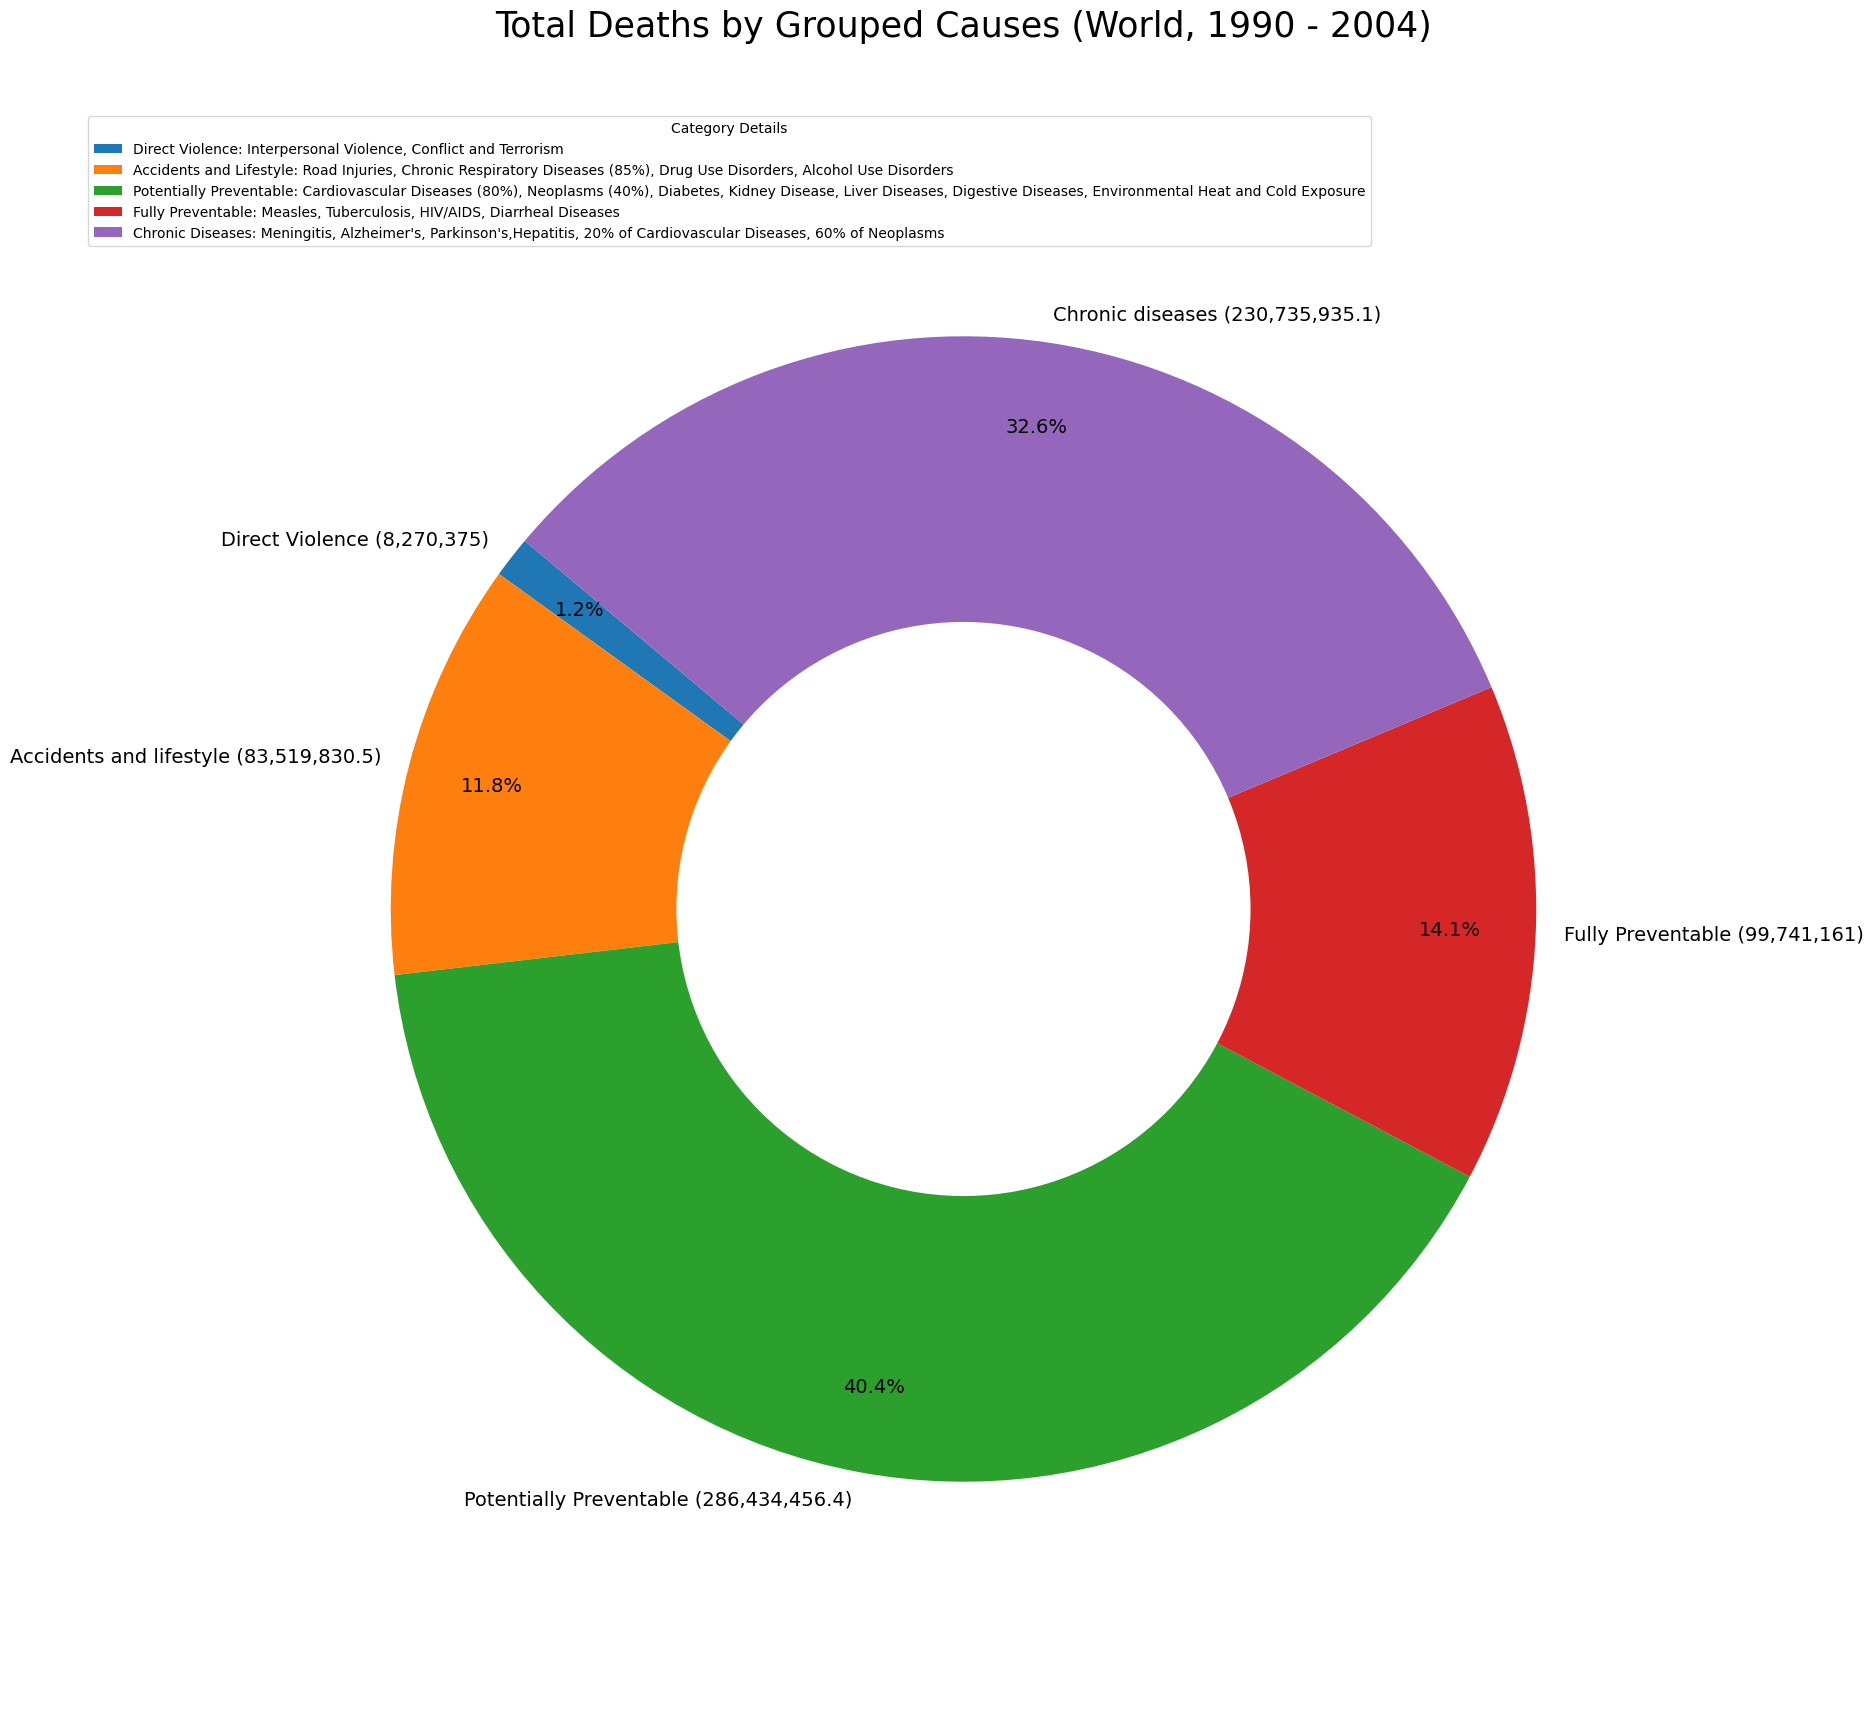

In [46]:
causes_totals = world_causes_result1.sum().sort_values(ascending=False)

# Define categories and calculate their totals
category_totals = {
    'Direct Violence': causes_totals['Interpersonal violence'] + causes_totals['Conflict and terrorism'],
    'Accidents and lifestyle': (causes_totals['Road injuries'] + 0.85 * causes_totals['Chronic respiratory diseases'] +
                        causes_totals['Drug use disorders'] + causes_totals['Alcohol use disorders'])+causes_totals['Self-harm']+causes_totals['Poisonings']+causes_totals['Drowning'],
    'Potentially Preventable': (0.8 * causes_totals['Cardiovascular diseases'] + 0.4 * causes_totals['Neoplasms'] +
                            causes_totals[['Diabetes mellitus', 'Chronic kidney disease', 'Cirrhosis and other chronic liver diseases',
                                            'Digestive diseases','Malaria', 'Environmental heat and cold exposure']].sum()),
    'Fully Preventable': causes_totals[['Measles', 'Tuberculosis', 'HIV/AIDS', 'Diarrheal diseases','Protein-energy malnutrition']].sum(),
    'Chronic diseases': (causes_totals[['Meningitis', "Alzheimer's disease and other dementias", "Parkinson's disease",
                                        'Nutritional deficiencies', 'Maternal disorders',
                                        'Lower respiratory infections', 'Neonatal disorders',
                                        'Acute hepatitis']].sum() +
                        0.15 * causes_totals['Chronic respiratory diseases'] +
                        0.2 * causes_totals['Cardiovascular diseases'] +
                        0.6 * causes_totals['Neoplasms'])
}

# Labels for the doughnut chart
labels = [f'{key} ({val:,})' for key, val in category_totals.items()]
values = list(category_totals.values())

# Plotting
fig, ax = plt.subplots(figsize=(18, 20))

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85, labeldistance=1.05, textprops={'fontsize': 14})

# Draw a circle at the center to create a doughnut chart
center_circle = plt.Circle((0, 0), 0.50, color='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Adding a detailed legend
legend_labels = [
    'Direct Violence: Interpersonal Violence, Conflict and Terrorism',
    'Accidents and Lifestyle: Road Injuries, Chronic Respiratory Diseases (85%), Drug Use Disorders, Alcohol Use Disorders',
    'Potentially Preventable: Cardiovascular Diseases (80%), Neoplasms (40%), Diabetes, Kidney Disease, Liver Diseases, Digestive Diseases, Environmental Heat and Cold Exposure',
    'Fully Preventable: Measles, Tuberculosis, HIV/AIDS, Diarrheal Diseases',
    'Chronic Diseases: Meningitis, Alzheimer\'s, Parkinson\'s,Hepatitis, 20% of Cardiovascular Diseases, 60% of Neoplasms'
]

legend = plt.legend(wedges, legend_labels, title="Category Details", loc='upper left', 
                bbox_to_anchor=(1, 1), fontsize=20, title_fontsize=15, frameon=True, framealpha=0.9)


plt.legend(wedges, legend_labels, title="Category Details", loc='upper left', bbox_to_anchor=(-0.2, 1))
plt.title('Total Deaths by Grouped Causes (World, 1990 - 2004)', y=1.04 , fontsize=25)
plt.axis('equal')  # Equal aspect ratio ensures that pie/doughnut is drawn as a circle.
plt.show()

Let's compare these results from 1990 - 2004 with the results from 2005 - 2019.

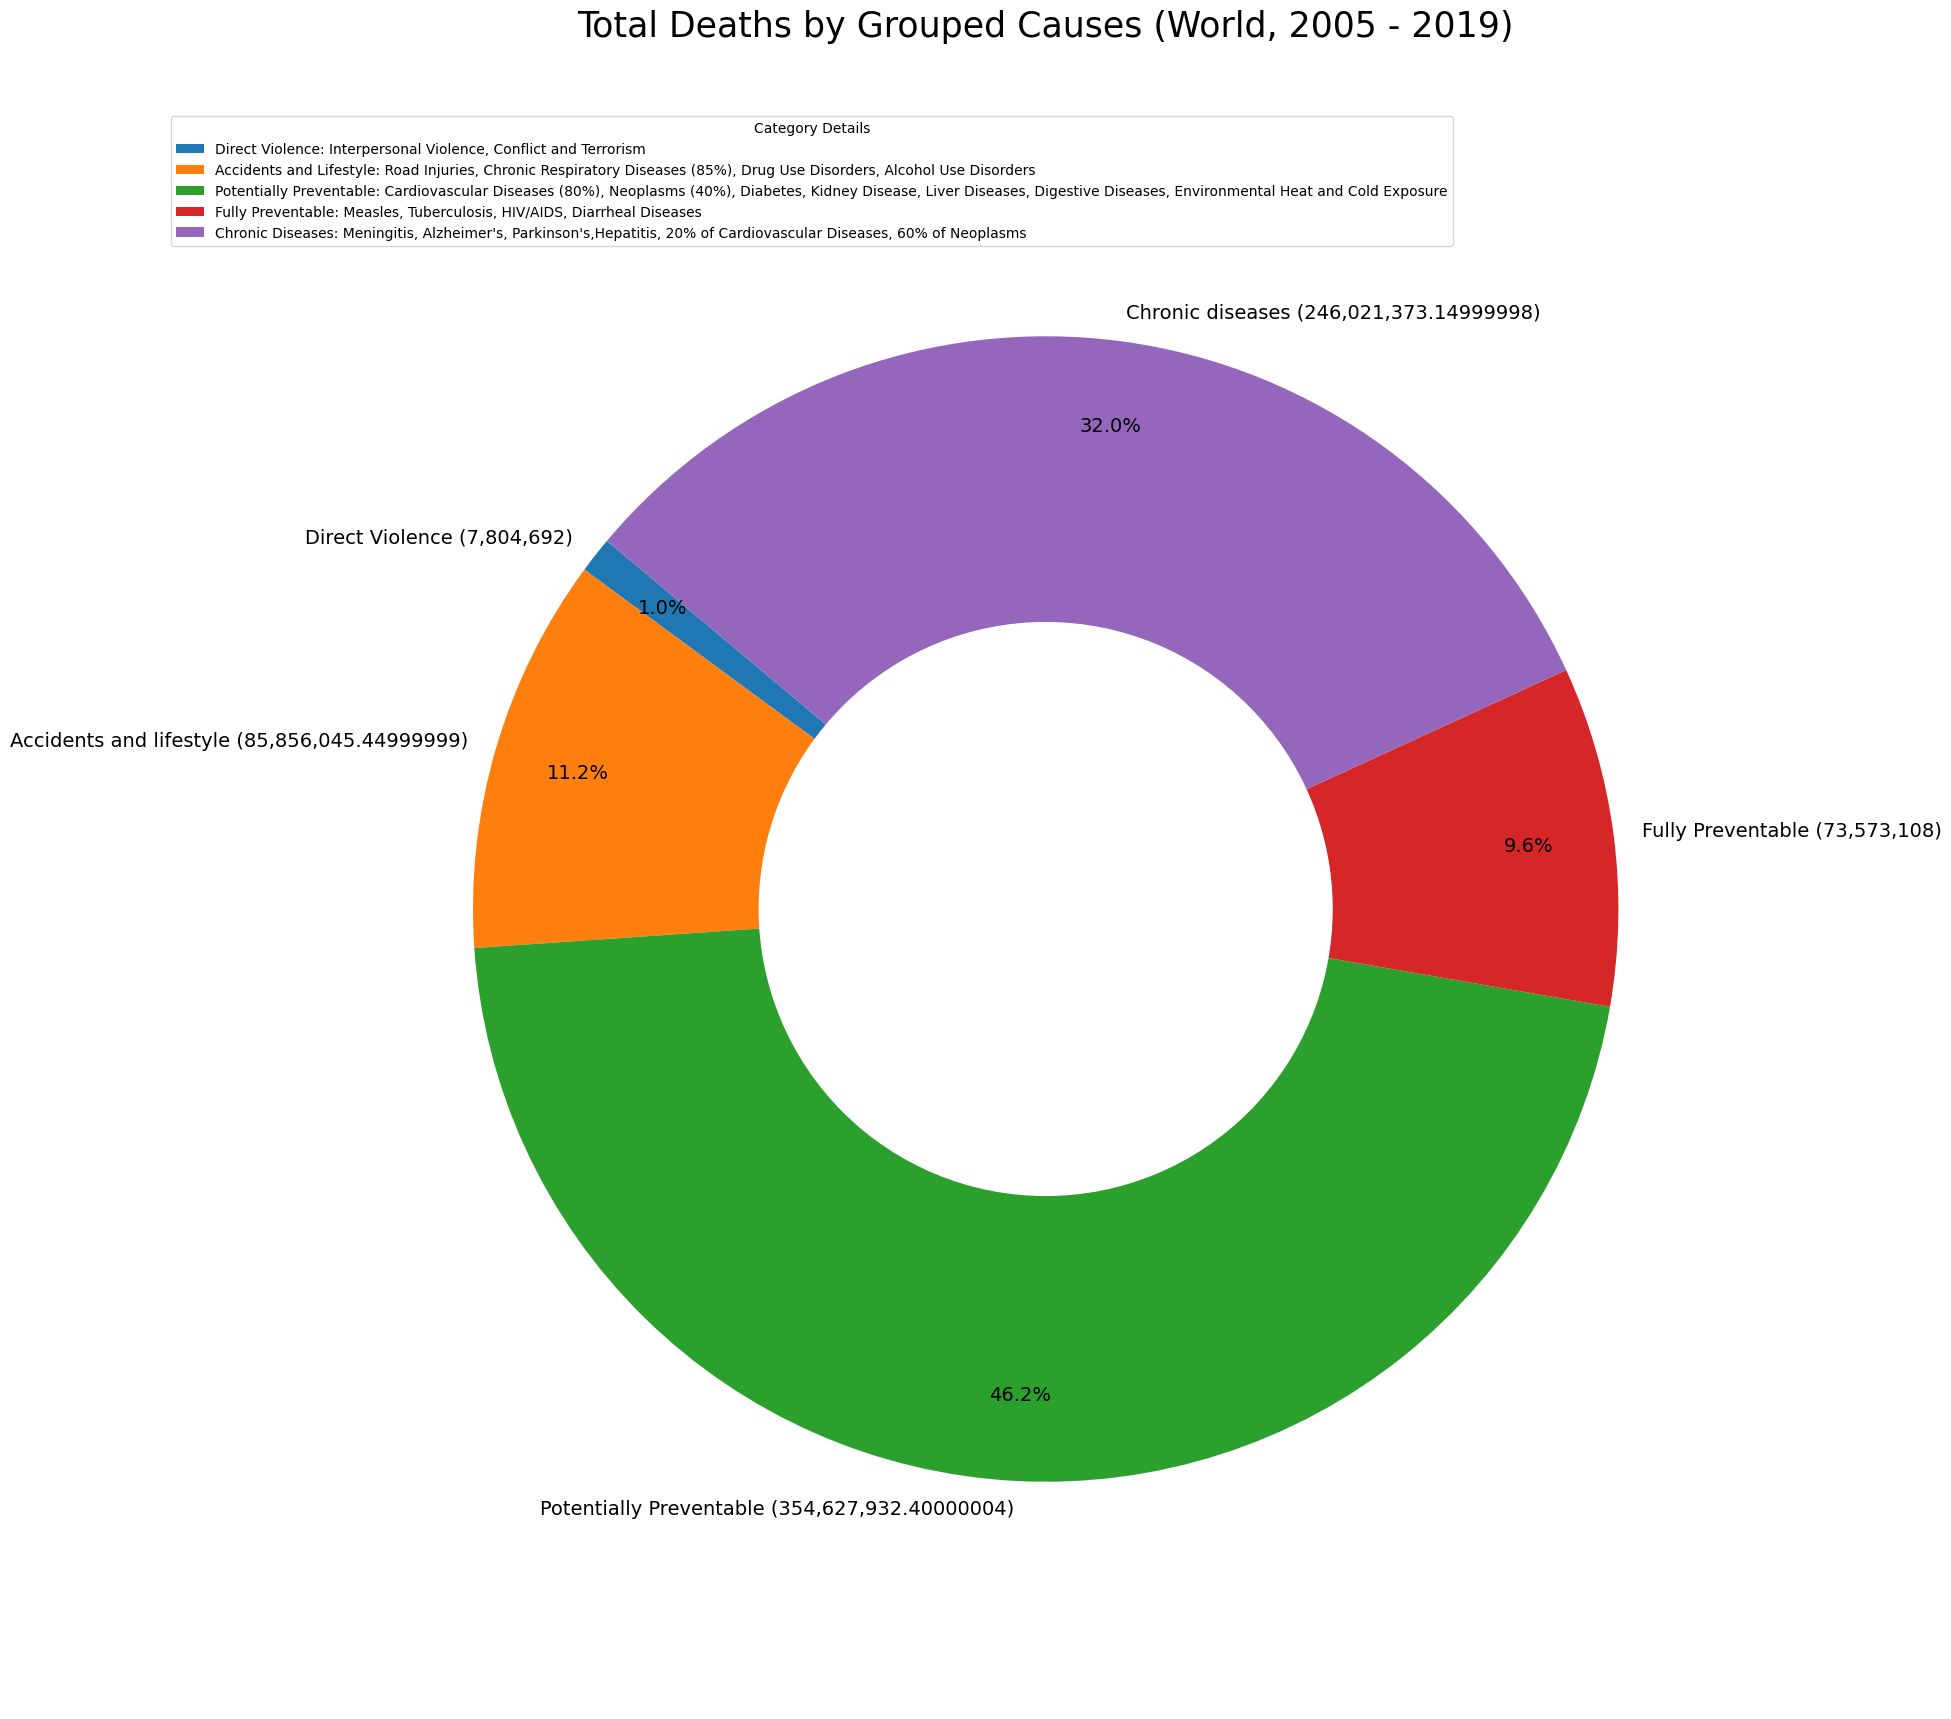

In [47]:
causes_totals = world_causes_result2.sum().sort_values(ascending=False)

# Define categories and calculate their totals
category_totals = {
    'Direct Violence': causes_totals['Interpersonal violence'] + causes_totals['Conflict and terrorism'],
    'Accidents and lifestyle': (causes_totals['Road injuries'] + 0.85 * causes_totals['Chronic respiratory diseases'] +
                        causes_totals['Drug use disorders'] + causes_totals['Alcohol use disorders'])+causes_totals['Self-harm']+causes_totals['Poisonings']+causes_totals['Drowning'],
    'Potentially Preventable': (0.8 * causes_totals['Cardiovascular diseases'] + 0.4 * causes_totals['Neoplasms'] +
                            causes_totals[['Diabetes mellitus', 'Chronic kidney disease', 'Cirrhosis and other chronic liver diseases',
                                            'Digestive diseases','Malaria', 'Environmental heat and cold exposure']].sum()),
    'Fully Preventable': causes_totals[['Measles', 'Tuberculosis', 'HIV/AIDS', 'Diarrheal diseases','Protein-energy malnutrition']].sum(),
    'Chronic diseases': (causes_totals[['Meningitis', "Alzheimer's disease and other dementias", "Parkinson's disease",
                                        'Nutritional deficiencies', 'Maternal disorders',
                                        'Lower respiratory infections', 'Neonatal disorders',
                                        'Acute hepatitis']].sum() +
                        0.15 * causes_totals['Chronic respiratory diseases'] +
                        0.2 * causes_totals['Cardiovascular diseases'] +
                        0.6 * causes_totals['Neoplasms'])
}

# Labels for the doughnut chart
labels = [f'{key} ({val:,})' for key, val in category_totals.items()]
values = list(category_totals.values())

# Plotting
fig, ax = plt.subplots(figsize=(18, 20))

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85, labeldistance=1.05, textprops={'fontsize': 14})

# Draw a circle at the center to create a doughnut chart
center_circle = plt.Circle((0, 0), 0.50, color='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Adding a detailed legend
legend_labels = [
    'Direct Violence: Interpersonal Violence, Conflict and Terrorism',
    'Accidents and Lifestyle: Road Injuries, Chronic Respiratory Diseases (85%), Drug Use Disorders, Alcohol Use Disorders',
    'Potentially Preventable: Cardiovascular Diseases (80%), Neoplasms (40%), Diabetes, Kidney Disease, Liver Diseases, Digestive Diseases, Environmental Heat and Cold Exposure',
    'Fully Preventable: Measles, Tuberculosis, HIV/AIDS, Diarrheal Diseases',
    'Chronic Diseases: Meningitis, Alzheimer\'s, Parkinson\'s,Hepatitis, 20% of Cardiovascular Diseases, 60% of Neoplasms'
]

legend = plt.legend(wedges, legend_labels, title="Category Details", loc='upper left', 
                bbox_to_anchor=(1, 1), fontsize=20, title_fontsize=15, frameon=True, framealpha=0.9)

plt.legend(wedges, legend_labels, title="Category Details", loc='upper left', bbox_to_anchor=(-0.2, 1))

plt.title('Total Deaths by Grouped Causes (World, 2005 - 2019)', y=1.04 , fontsize=25)
plt.axis('equal')  # Equal aspect ratio ensures that pie/doughnut is drawn as a circle.
plt.show()

# Estimated trends

Comparing these two charts we thought we could see the following trends in these CoD:

* Significant decline in Direct Violence (17% decline)

* Slight decline in Accidents and Lifestyle (5% decline)

* Significant decline in Fully Preventable (32% decline)

* Moderate rise in Potentially Preventable (14% rise)

* Chronic Diseases staying almost static. (2% rise)

# Further examination of trends

Let's dive deeper in some trends with some graphs.

First one up is Fully Preventable Causes.

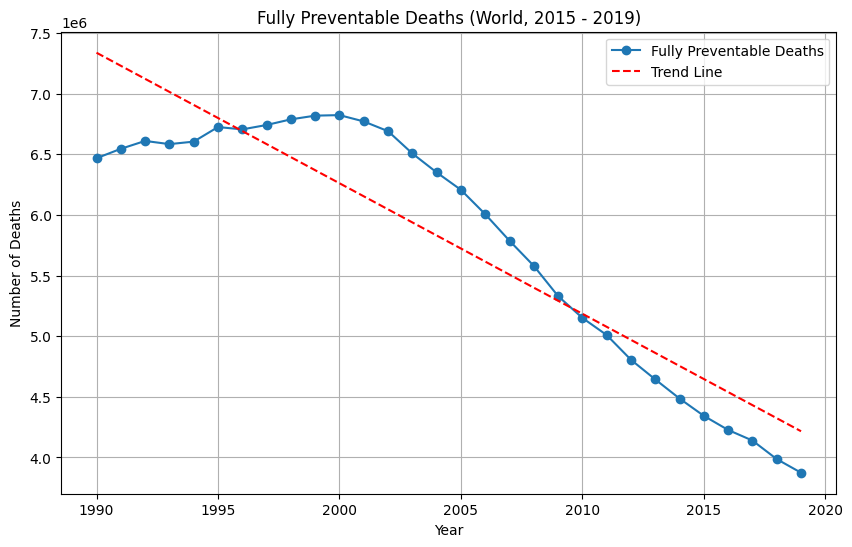

In [48]:
conn = sqlite3.connect('deathdata.db')

# Query to get the total deaths for specified causes for 'World' by year
world_causes_query = """
SELECT 
    Year,
    SUM("Deaths - Measles - Sex: Both - Age: All Ages (Number)") AS "Measles",
    SUM("Deaths - Tuberculosis - Sex: Both - Age: All Ages (Number)") AS "Tuberculosis",
    SUM("Deaths - HIV/AIDS - Sex: Both - Age: All Ages (Number)") AS "HIV/AIDS",
    SUM("Deaths - Diarrheal diseases - Sex: Both - Age: All Ages (Number)") AS "Diarrheal diseases",
    SUM("Deaths - Protein-energy malnutrition - Sex: Both - Age: All Ages (Number)") AS "Protein-energy malnutrition"
FROM death_causes
WHERE Entity = 'World'
GROUP BY Year
ORDER BY Year
"""

# Execute the query and store the result in a DataFrame
world_causes_result = pd.read_sql(world_causes_query, conn)

conn.close()

# Check if data is available and process it
if not world_causes_result.empty and not world_causes_result.isna().all().all():
    # Calculate the 'Fully Preventable' totals for each year
    world_causes_result['Fully Preventable'] = (
        world_causes_result['Measles'] +
        world_causes_result['Tuberculosis'] +
        world_causes_result['HIV/AIDS'] +
        world_causes_result['Diarrheal diseases'] +
        world_causes_result['Protein-energy malnutrition']
    )

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(world_causes_result['Year'], world_causes_result['Fully Preventable'], marker='o', label='Fully Preventable Deaths')

    # Adding a trend line
    z = np.polyfit(world_causes_result['Year'], world_causes_result['Fully Preventable'], 1)
    p = np.poly1d(z)
    plt.plot(world_causes_result['Year'], p(world_causes_result['Year']), linestyle='--', color='r', label='Trend Line')

    plt.title('Fully Preventable Deaths (World, 2015 - 2019)')
    plt.xlabel('Year')
    plt.ylabel('Number of Deaths')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data available for 'World' or data is incomplete.")

Next, let's look at Direct Violence.

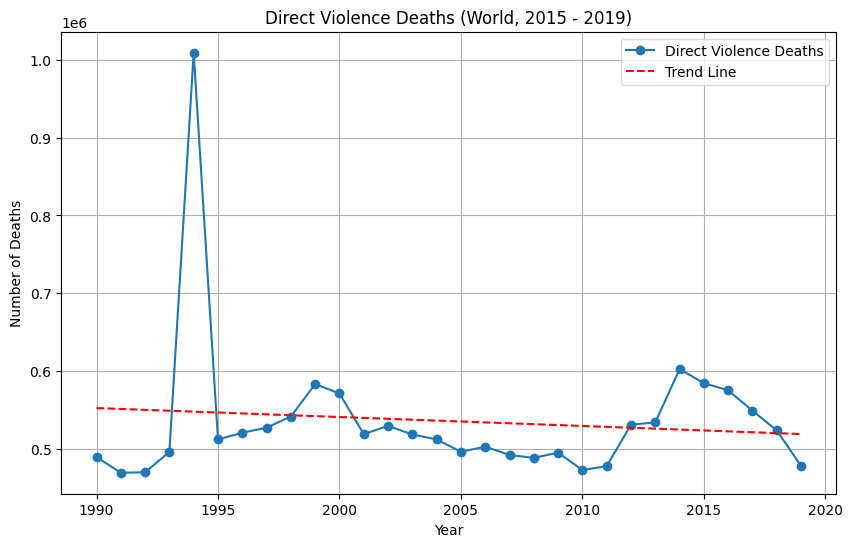

In [49]:
conn = sqlite3.connect('deathdata.db')

# Query to get the total deaths for each cause for 'World' by year
world_causes_query = """
SELECT 
    Year,
    SUM("Deaths - Interpersonal violence - Sex: Both - Age: All Ages (Number)") AS "Interpersonal violence",
    SUM("Deaths - Conflict and terrorism - Sex: Both - Age: All Ages (Number)") AS "Conflict and terrorism"
FROM death_causes
WHERE Entity = 'World'
GROUP BY Year
ORDER BY Year
"""

# Execute the query and store the result in a DataFrame
world_causes_result = pd.read_sql(world_causes_query, conn)

conn.close()

# Check if data is available and process it
if not world_causes_result.empty and not world_causes_result.isna().all().all():
    # Calculate the 'Direct Violence' totals for each year
    world_causes_result['Direct Violence'] = (
        world_causes_result['Interpersonal violence'] +
        world_causes_result['Conflict and terrorism']
    )

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(world_causes_result['Year'], world_causes_result['Direct Violence'], marker='o', label='Direct Violence Deaths')

    # Adding a trend line
    z = np.polyfit(world_causes_result['Year'], world_causes_result['Direct Violence'], 1)
    p = np.poly1d(z)
    plt.plot(world_causes_result['Year'], p(world_causes_result['Year']), linestyle='--', color='r', label='Trend Line')

    plt.title('Direct Violence Deaths (World, 2015 - 2019)')
    plt.xlabel('Year')
    plt.ylabel('Number of Deaths')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data available for 'World' or data is incomplete.")


Looking at this graph we see a clear limitation in the data. To spot a clear trend in this case, we would need more time in the data.

If we were to analyze this data still, we see a general trend of decrease in Direct Violence interrupted by sudden upswings caused by large conflicts.

# Neonatal deaths

Let's see what we can find when we get more specific.

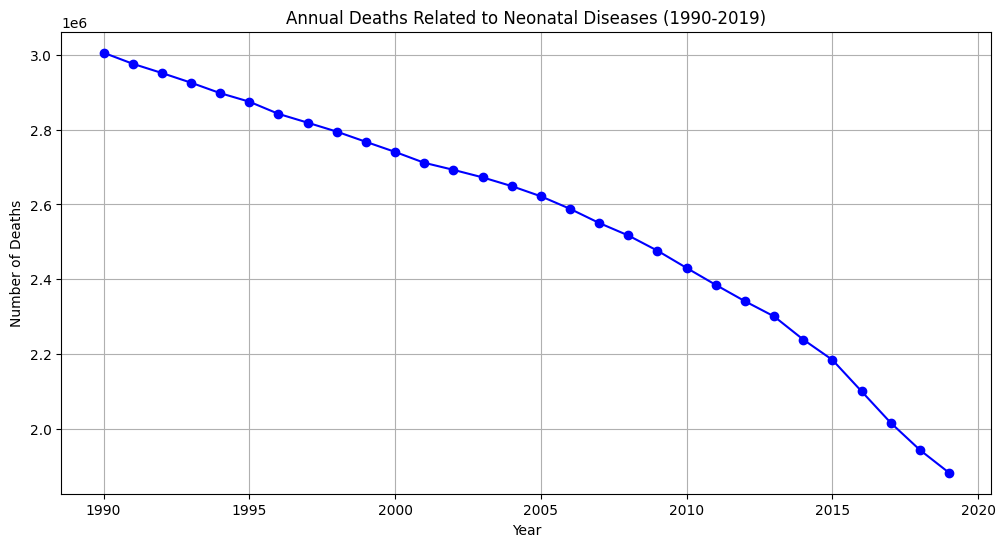

In [50]:
conn = sqlite3.connect('deathdata.db')

query = """
SELECT 
    Year,
    SUM("Deaths - Neonatal disorders - Sex: Both - Age: All Ages (Number)") AS "Neonatal Diseases"
FROM death_causes
WHERE Entity = 'World' AND Year BETWEEN 1990 AND 2019
GROUP BY Year
ORDER BY Year
"""

# Execute the SQL query and fetch data into a DataFrame
data = pd.read_sql(query, conn)

conn.close()

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(data['Year'], data['Neonatal Diseases'], marker='o', linestyle='-', color='b')
plt.title('Annual Deaths Related to Neonatal Diseases (1990-2019)')
plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.grid(True)
plt.show()

# Bonus fact

The least common cause of death is:

In [51]:
conn = sqlite3.connect('deathdata.db')

query = """
SELECT 
    MIN(Total_Deaths) AS Least_Deaths,
    Cause
FROM (
    SELECT SUM("Deaths - Meningitis - Sex: Both - Age: All Ages (Number)") AS Total_Deaths, 'Meningitis' AS Cause FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Alzheimer's disease and other dementias - Sex: Both - Age: All Ages (Number)"), 'Alzheimer''s disease and other dementias' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Parkinson's disease - Sex: Both - Age: All Ages (Number)"), 'Parkinson''s disease' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Nutritional deficiencies - Sex: Both - Age: All Ages (Number)"), 'Nutritional deficiencies' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Malaria - Sex: Both - Age: All Ages (Number)"), 'Malaria' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Drowning - Sex: Both - Age: All Ages (Number)"), 'Drowning' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Interpersonal violence - Sex: Both - Age: All Ages (Number)"), 'Interpersonal violence' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Maternal disorders - Sex: Both - Age: All Ages (Number)"), 'Maternal disorders' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - HIV/AIDS - Sex: Both - Age: All Ages (Number)"), 'HIV/AIDS' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Drug use disorders - Sex: Both - Age: All Ages (Number)"), 'Drug use disorders' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Tuberculosis - Sex: Both - Age: All Ages (Number)"), 'Tuberculosis' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Cardiovascular diseases - Sex: Both - Age: All Ages (Number)"), 'Cardiovascular diseases' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Lower respiratory infections - Sex: Both - Age: All Ages (Number)"), 'Lower respiratory infections' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Neonatal disorders - Sex: Both - Age: All Ages (Number)"), 'Neonatal disorders' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Alcohol use disorders - Sex: Both - Age: All Ages (Number)"), 'Alcohol use disorders' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Self-harm - Sex: Both - Age: All Ages (Number)"), 'Self-harm' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Exposure to forces of nature - Sex: Both - Age: All Ages (Number)"), 'Exposure to forces of nature' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Diarrheal diseases - Sex: Both - Age: All Ages (Number)"), 'Diarrheal diseases' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Environmental heat and cold exposure - Sex: Both - Age: All Ages (Number)"), 'Environmental heat and cold exposure' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Neoplasms - Sex: Both - Age: All Ages (Number)"), 'Neoplasms' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Conflict and terrorism - Sex: Both - Age: All Ages (Number)"), 'Conflict and terrorism' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Diabetes mellitus - Sex: Both - Age: All Ages (Number)"), 'Diabetes mellitus' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Chronic kidney disease - Sex: Both - Age: All Ages (Number)"), 'Chronic kidney disease' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Poisonings - Sex: Both - Age: All Ages (Number)"), 'Poisonings' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Protein-energy malnutrition - Sex: Both - Age: All Ages (Number)"), 'Protein-energy malnutrition' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Road injuries - Sex: Both - Age: All Ages (Number)"), 'Road injuries' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Chronic respiratory diseases - Sex: Both - Age: All Ages (Number)"), 'Chronic respiratory diseases' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Cirrhosis and other chronic liver diseases - Sex: Both - Age: All Ages (Number)"), 'Cirrhosis and other chronic liver diseases' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Digestive diseases - Sex: Both - Age: All Ages (Number)"), 'Digestive diseases' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Fire, heat, and hot substances - Sex: Both - Age: All Ages (Number)"), 'Fire, heat, and hot substances' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Acute hepatitis - Sex: Both - Age: All Ages (Number)"), 'Acute hepatitis' FROM death_causes
    UNION ALL
    SELECT SUM("Deaths - Measles - Sex: Both - Age: All Ages (Number)"), 'Measles' FROM death_causes
) AS Summed_Causes
GROUP BY Cause
ORDER BY Least_Deaths ASC
LIMIT 1;
"""
query_result = pd.read_sql(query, conn)

conn.close()

print(query_result)

   Least_Deaths                         Cause
0       8061257  Exposure to forces of nature


# Final thoughts

Negatives:

* We found that some "luxury diseases", ones that seem to rise with economies growing and more people reaching older age, IE cardiovascular diseases are rising. They are likely correlated with fast foods becoming more available, lifestyles becoming more sedentary and people reaching higher ages. 

* Wars seem to be unpredictable. Although there seems to be a general downwards trend there always seems to be a looming threat of wars breaking out.

Positives: 

* Although the CoD "Potentially Preventable" seem to be rising somewhat, many of these are "luxury diseases", their becoming more common can largely be attributed to increasing global welfare.

* Although the CoD "Direct Conflict" didn't seem to be going away in the near future we found that it is one a very small fraction of the total CoD.

* The CoD "Fully Preventable" seems to be declining consistently since the year 2000, which indicates we are getting closer to removing these issues entirely.

# Postlude

By analyzing this data set we found that, contrary to popular belief, a lot of things seem to be improving.

This is consistent with Hans Rosling's (1948 - 2017) thesis that monkeys have a better understanding than humans about the state of the world, since they consistently score better on tests.

Try doing some tests on gapminder.org if you are interested.